<a href="https://colab.research.google.com/github/PascalPolygon/AffineCNN/blob/main/translation_vector_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSE 5290: Translation Vector Estimation (Graduate Student Project)**
Pascal Dao (pdao2015@my.fit.edu) and Ruksana Kabealo (rkabealo@my.fit.edu) \
Florida Institute of Technology — September 11th, 2021 through XXXXX

This code generates the "Shape Movements Dataset" - a dataset of various 2D shapes experiencing the following affine transformations: translation, rotation, and scaling. 

This becomes a 6 Degrees of Freedom system. As such, we save our transformation as the 6 usable values from the affine matrix: a, b, c, d, e, and f. 

We will be using matplotlib to generate the shapes. 

**TODO: **

Ruksana: 
* given a bounding box, generate a randomly sized polygon at a random center POINT within (make sure to check appropriately to make sure it's not initially generated offscreen) 
* somehow pass the max ability to be translated to the translation function so it's distribution changes and it never moves the polygon off screen 
* figure out how to incorporate curved polygons into generated translations 

Pascal: 
* fix the data loader problems
* start working on setting up the online transformations code 

For the meeting
* Decide on an image width/height and stick to it

## Code

### Imports and Configuration

Import necessary libraries. 

In [23]:
# Imports
#from ipycanvas import Canvas, hold_canvas, MultiCanvas
import math 
import numpy as np
from numpy.random import default_rng
import csv
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Arc, Ellipse, RegularPolygon, PathPatch
import matplotlib.path as mpath 
import bisect 
import operator
import collections
from google.colab import drive
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

Set up where we'll be saving the data.

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH_TO_ORIGINAL_IMGS = '/content/drive/MyDrive/translation_vector_estimation_project/data/input/original'
PATH_TO_TRANSLATED_IMGS = '/content/drive/MyDrive/translation_vector_estimation_project/data/input/translated'
PATH_TO_LABELS = '/content/drive/MyDrive/translation_vector_estimation_project/data/labels'

Create default dimensions for the images. 

In [7]:
# Image dimensions 
IMG_WIDTH = 256
X_AXIS_LIM = IMG_WIDTH/2
IMG_HEIGHT = 256
Y_AXIS_LIM = IMG_HEIGHT/2
MIN_RADIUS = 12
MAX_RADIUS = 128

## Shape Generation


TODO: explain further the decision making process behind what we're doing. Why these categories. 

The different types of shapes considered for this project are: 
* Regular polygons 
* Ellipses
* Randomly generated convex polygons (using Valtr's algorithm)
* Randomly generated with random curve incorporation (matplotlib path + bezel curves 3 and 4) 

We developed the code for generating these different types of shapes.

### Regular Polygon Generation

#### Generation Function

In [ ]:
"""
This function takes in: 
* the center coordinates (x and y)
* a radius length
* the number of points for the polygon 

and returns: 
* a regular n-sided polygon with the specified radius
"""
def generate_regular_polygon(center_x, center_y, number_of_points):
    # Check for invalid input
    if number_of_points <= 2: 
        print("Invalid number of points!")
        return -1
    else: 
        p = RegularPolygon((center_x, center_y), number_of_points, radius, facecolor='k')
        return p

#### Example

Below is an example of generating a regular 6-sided polygon. 

In [ ]:
"""
Get the vertices for a 6-sided polygon centered around (0,0) that has the radius specified 
"""
example_regular_6_side_poly = generate_regular_polygon(0, 0, 6)

# Create figure 
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
padding = 15

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-X_AXIS_LIM, X_AXIS_LIM])
axs[0].set_ylim([-Y_AXIS_LIM, Y_AXIS_LIM])

vertices = example_regular_6_side_poly.get_path().vertices
trans = example_regular_6_side_poly.get_patch_transform()
points = trans.transform(vertices)

pts = list(zip(*points))
axs[0].scatter(pts[0],pts[1], c='k')

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
axs[1].add_patch(example_regular_6_side_poly)

plt.show()

TypeError: ignored

### Ellipse Polygon Generation

#### Generation Function

In [ ]:
"""
This function takes in: 
* the center coordinates (x and y)
* a maximum width 
* a maximum height 

and returns: 
* an ellipse patch centered at (x,y) with a random width between 
[max_width/10, max_width] and a random height between [max_height/10, max_height] 
and with a random tilt between [0,360] degrees
"""
def generate_ellipse(center_x, center_y, max_width, max_height):
    # Minimum size is a 10th of the space it could be generated in
    random_width = np.random.randint(max_width/10, max_width)
    random_height = np.random.randint(max_height/10, max_height)
    
    # We can't have the randomly generated width/height ending up too close together 
    # If they do - our ellipse will look too much like a circle for our algorithm to distinguish 
    # Let's ensure that the randomly generated ellipse never exceeds 1:2/2:1 width:height/height:width ratio 
    while abs(random_width/random_height) > 1/2 and abs(random_width/random_height) < 2/1:
        random_width = np.random.randint(max_width/10, max_width)
        random_height = np.random.randint(max_height/10, max_height)
    
    # Generate a random tilt 
    random_tilt = np.random.randint(0, 360)
    
    # Compile the final patch
    e = Ellipse((center_x, center_y), random_width, random_height, angle=random_tilt, facecolor='k',fill=True)
    
    return e

#### Example

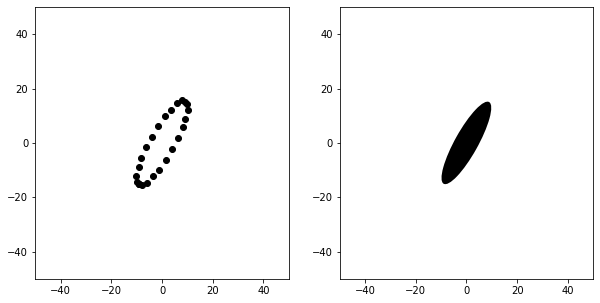

In [ ]:
"""
Get the vertices for an ellipse centered around (0,0) that is contained within -25 and +25 on the x-axis 
and -25 and +25 on the y-axis
"""
example_ellipse = generate_ellipse(0, 0, 50, 50)

# Create figure 
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

verts = example_ellipse.get_path().vertices
trans = example_ellipse.get_patch_transform()
points = trans.transform(verts)

pts = list(zip(*points))
axs[0].scatter(pts[0],pts[1], c='k')

# Plot the ellipse as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
axs[1].add_patch(example_ellipse)

plt.show()

### Randomly Generated Convex Polygon Generation (Valtr's Algorithm)

TODO: Credit Valt'rs algorithm to the right source

#### Generation Function

In [ ]:
"""
This function takes in: 
* the center coordinates (x and y) of some area to generate the polygon within 
* the width of the area to generate the polygon within 
* the height of the area to generate the polygon within 
* the number of points for the polygon 

and returns: 
* the vertices for a randomly generated convex polygon - in counterclockwise order of the convex hull 
"""
def generate_random_convex_polygon(center_x, center_y, max_width, max_height, number_of_points):
    # Figure out the bounding box for where we're generating this arbitrary polygon 
    min_x = center_x - (max_width / 2.0) 
    max_x = center_x + (max_width / 2.0) 
    min_y = center_y - (max_height / 2.0)
    max_y = center_y + (max_height / 2.0)
    
#     print("""Creating bounding box from {min_x} to {max_x} in the x-direction and {min_y} to {max_y} in the y-direction""".format(min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y))
    
    # Generate two sorted lists of random x and y coordinates 
    random_x_coordinates = np.sort(np.random.randint(min_x, max_x, size=number_of_points))
    random_y_coordinates = np.sort(np.random.randint(min_y, max_y, size=number_of_points))
    
#     print("Randomly generated x coordinates: {lx}".format(lx=str(random_x_coordinates)))
#     print("Randomly generated y coordinates: {ly}".format(ly=str(random_y_coordinates)))
    
    # Get the biggest and smallest values (the "extreme" points)
    # The list is sorted - so we can grab the first and last elements
    max_x = random_x_coordinates[-1]
    max_y = random_y_coordinates[-1]
    min_x = random_x_coordinates[0]
    min_y = random_y_coordinates[0]
    
#     print("Extreme x coordinates: {min_x} (smallest) and {max_x} (biggest)".format(min_x=min_x, max_x=max_x))
#     print("Extreme x coordinates: {min_y} (smallest) and {max_y} (biggest)".format(min_y=min_y, max_y=max_y))
    
    # Randomly divide the non-extreme points into two chains
    # Extreme are found at 0 and at len-1 
    x_vec = np.empty(number_of_points)
    y_vec = np.empty(number_of_points)
    
    # x vector 
    last_seen_top = min_x
    last_seen_bottom = min_x
    
    # For each non-extreme point...
    for i in range(1, number_of_points - 1):
        x = random_x_coordinates[i]
        
        if(bool(random.randrange(2))): 
            x_vec[i - 1] = x - last_seen_top
            last_seen_top = x
        else: 
            x_vec[i - 1] = last_seen_bottom - x 
            last_seen_bottom = x
           
    x_vec[number_of_points - 2] = max_x - last_seen_top 
    x_vec[number_of_points - 1] = last_seen_bottom - max_x
    
    # y vector 
    last_seen_right = min_y
    last_seen_left = min_y
    
    for i in range(1, number_of_points - 1):
        temp_y = random_y_coordinates[i]
        
        if(bool(random.randrange(2))): 
            y_vec[i - 1] = temp_y - last_seen_left
            last_seen_left = temp_y
        else:
            y_vec[i - 1] = last_seen_right - temp_y
            last_seen_right = temp_y
    
    y_vec[number_of_points - 2] = max_y - last_seen_left
    y_vec[number_of_points - 1] = last_seen_right - max_y
    
    # Randomly pair the x and ys 
    random.shuffle(y_vec)
    
    # Combine the paired up components into vectors
    def find_vector_angle(v): 
        return math.atan2(v[1], v[0]) 
    
    # Sort the vectors by angle
    vectors = np.array(sorted(zip(x_vec, y_vec), key = find_vector_angle))
    
#     print("VECTORS:")
#     print(vectors)

    # Lay them end-to-end
    new_x = 0 
    new_y = 0 
    min_polygon_x = 0 
    min_polygon_y = 0
    
    points = []

    for vector_x, vector_y in vectors: 
        points.append((new_x, new_y))
        
        new_x += vector_x
        new_y += vector_y
        
        min_polygon_x = min(min_polygon_x, new_x)
        min_polygon_y = min(min_polygon_y, new_y)
        
        
    # Move the polygon to the original min and max coordinates
    shift_x = min_x - min_polygon_x;
    shift_y = min_y - min_polygon_y;
        
    points = [(point_x + shift_x, point_y + shift_y) for point_x, point_y in points]
    
#     print("POINTS")
#     print(points)
    return np.array(points)

#### Example

To show that our implementation of Valtr's Algorithm works as we expect it to - we can generate the points for an 6-sided polygon and plot it. 

TypeError: ignored

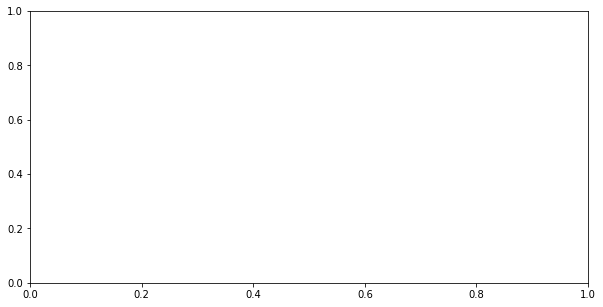

In [ ]:
"""
Get the vertices for a 6-sided polygon centered around (0,0) that is contained within -25 and +25 on the x-axis 
and -25 and +25 on the y-axis
"""
#example_random_convex_6_size_poly = generate_random_convex_polygon(0, 0, 50, 50, 6)

# Create figure 
fig, axs = plt.subplots(figsize=(10,5))

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

pts = list(zip(*example_random_convex_6_size_poly))
print("Vertices are: " + str(example_random_convex_6_size_poly))
axs[0].scatter(pts[0],pts[1], c='k')

for i,v in enumerate(example_random_convex_6_size_poly):
    axs[0].annotate("V" + str(i), (v[0], v[1]))

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
poly = Polygon(example_random_convex_6_size_poly, facecolor='k')
axs[1].add_patch(poly)

plt.show()

### Randomly Generated Convex Polygon with Bezier Curves Generation

#### Generation Function

In [ ]:
"""
This function assumes: 
* the vertices are given in either a clockwise or counterclockwise 
ordering of the convex hull 

and takes in: 
* a list of vertices describing a convex polygon

and returns: 
* n new patchs describing n new polygons - one for a quadratic Bezier 
curve taking the place of each edge 
"""
def generate_quad_Beziered_convex_polygons(vertices):
    num_vertices = len(vertices)
    codes_default = [1]
    
    name = 0
    
    # Quadratic
    codes_quad_transform = [3,3] + ([2] * (num_vertices-3))
    for i in range(num_vertices-2): 
        codes = codes_default + codes_quad_transform[-i:] + codes_quad_transform[:-i]

        path = mpath.Path(vertices, codes)

        curve_points = [i for i, j in zip(vertices, codes) if j==3]

        print("Quadratic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("quad_" + str(name) + ".png", dpi=400)
        name += 1
        
    for i in [2,1]:
        shifted_vertices = collections.deque(vertices)
        shifted_vertices.rotate(i)
        shifted_vertices = list(shifted_vertices)
        codes = codes_default + codes_quad_transform 
        
        path = mpath.Path(shifted_vertices, codes)

        curve_points = [i for i, j in zip(shifted_vertices, codes) if j==3]

        print("Quadratic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("quad_" + str(name) + ".png", dpi=400)
        name += 1

In [ ]:
print("Vertices are: ")
print(example_random_convex_6_size_poly)

generate_quad_Beziered_convex_polygons(example_random_convex_6_size_poly)

Vertices are: 


NameError: ignored

In [ ]:
"""

"""
def generate_cub_Beziered_convex_polygons(vertices):
    num_vertices = len(vertices)
    codes_default = [1]
    
    name = 0
    
    # Quadratic
    codes_quad_transform = [4,4,4] + ([2] * (num_vertices-4))
    for i in range(num_vertices-3): 
        codes = codes_default + codes_quad_transform[-i:] + codes_quad_transform[:-i]

        path = mpath.Path(vertices, codes)

        curve_points = [i for i, j in zip(vertices, codes) if j==4]

        print("Cubic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("cubic_" + str(name) + ".png", dpi=400)
        name += 1
        
    for i in [3,2,1]:
        shifted_vertices = collections.deque(vertices)
        shifted_vertices.rotate(i)
        shifted_vertices = list(shifted_vertices)
        codes = codes_default + codes_quad_transform 
        
        path = mpath.Path(shifted_vertices, codes)

        curve_points = [i for i, j in zip(shifted_vertices, codes) if j==4]

        print("Cubic Bezier curve applied to the following points: ") 
        for i in curve_points: 
            print("* " + str(i))
        fig, axs = plt.subplots(figsize=(10,5))
        patch = PathPatch(path, facecolor='k', fill=True, lw=2)
        axs.add_patch(patch)
        crv_pts = list(zip(*curve_points))
        axs.scatter(pts[0], pts[1], c='r', marker='x')
        axs.scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
        axs.set_xlim([-50, 50])
        axs.set_ylim([-50, 50])
        fig.savefig("cubic_" + str(name) + ".png", dpi=400)
        name += 1

In [ ]:
print("Vertices are: ")
print(example_random_convex_6_size_poly)

generate_cub_Beziered_convex_polygons(example_random_convex_6_size_poly)

#### Example

Here we use a 6-sided polygon randomly generated by the algorithm above. 

In [ ]:
"""
Show an example of a quadratic bezier curve between two points on a randomly generated 6-sided polygon
"""
vertices = example_random_convex_6_size_poly

#[[-23, 5], [-23, -10], [8,-17], [22,-13.], [16,-6], [0, -1]]

fig, axs = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('6-Sided Randomly Generated Convex Polygon with Quadratic Bezier Curve', fontsize=16)

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

print("Vertices are:" + str(vertices))
pts = list(zip(*vertices))
axs[0].scatter(pts[0],pts[1], c='r', marker='x')
for i,v in enumerate(vertices):
    axs[0].annotate("(" + str(v[0]) + ", " + str(v[1]) + ")", (v[0], v[1]))

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
poly = Polygon(vertices, facecolor='k')
axs[1].add_patch(poly)
axs[1].scatter(pts[0],pts[1], c='r', marker='x')

codes = [
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.CURVE3,
    mpath.Path.CURVE3,
]

print(codes)

path = mpath.Path(vertices, codes)

curve_points = [vertices[1], vertices[2], vertices[5]]

#[i for i, j in zip(vertices, codes) if j==3]

print("Quadratic Bezier curve applied to the following points: ") 
for i in curve_points: 
    print("* " + str(i))
    
patch = PathPatch(path, facecolor='k', fill=True, lw=2)
axs[2].add_patch(patch)
crv_pts = list(zip(*curve_points))
axs[2].scatter(pts[0], pts[1], c='r', marker='x')
axs[2].scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
axs[2].set_xlim([-50, 50])
axs[2].set_ylim([-50, 50])

In [ ]:
"""
Show an example of a cubic bezier curve between three points on a randomly generated 6-sided polygon
"""
#vertices = example_random_convex_6_size_poly

print(vertices)

fig, axs = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('6-Sided Randomly Generated Convex Polygon with Cubic Bezier Curve', fontsize=16)

# Plot the 6-sided polygon as a list of points 
axs[0].set_xlim([-50, 50])
axs[0].set_ylim([-50, 50])

pts = list(zip(*vertices))
axs[0].scatter(pts[0],pts[1], c='r', marker='x')
for i,v in enumerate(vertices):
    axs[0].annotate("(" + str(v[0]) + ", " + str(v[1]) + ")", (v[0], v[1]))

# Plot the 6-sided polygon as a filled-in shape 
axs[1].set_xlim([-50, 50])
axs[1].set_ylim([-50, 50])
poly = Polygon(vertices, facecolor='k')
axs[1].add_patch(poly)
axs[1].scatter(pts[0],pts[1], c='r', marker='x')

codes = [
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.CURVE4,
    mpath.Path.CURVE4,
    mpath.Path.CURVE4,
]

path = mpath.Path(vertices, codes)

curve_points = [vertices[2], vertices[3], vertices[4], vertices[5]] #[i for i, j in zip(vertices, codes) if j==4]

print("Cubic Bezier curve applied to the following points: ") 
for i in curve_points: 
    print("* " + str(i))

patch = PathPatch(path, facecolor='k', fill=True, lw=2)
axs[2].add_patch(patch)
crv_pts = list(zip(*curve_points))
axs[2].scatter(pts[0], pts[1], c='r', marker='x')
axs[2].scatter(crv_pts[0], crv_pts[1], c='g', marker='x')
axs[2].set_xlim([-50, 50])
axs[2].set_ylim([-50, 50])

In [ ]:
datasetSize = 1500
for i in range(datasetSize):
#Original
  filename = str(i)
  filepath = os.path.join(PATH_TO_ORIGINAL_IMGS, filename)

  verts = generate_random_convex_polygon(0, 0, 50, 50, 7)
  savePoly(verts, filepath)

  #Transormation
  filepath = os.path.join(PATH_TO_TRANSLATED_IMGS, filename)

  # Random transformation paratmers
  dx = np.random.uniform(-20,20,1)[0]
  dy = np.random.uniform(-20,20,1)[0]
  theta = np.random.uniform(0,360,1)[0]
  sx = np.random.uniform(0.4,2,1)[0]
  sy = np.random.uniform(0.4,2,1)[0]

  params = np.array([dx, dy, theta, sx, sy])
  A, S = getTransformations(params)
  verts_t = applyTranformation(verts, A, S)
  savePoly(verts_t, filepath)

  #Save label (transformation params)
  filepath = os.path.join(PATH_TO_LABELS, filename)
  np.save(filepath+'.npy', params)

## Generating dataset

## Dataset Loader

In [3]:
class AffineDataset(Dataset):
  def __init__(self, img_dir, img_t_dir, annotations_dir, transform=None, target_transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        # self.img_labels = np.load(annotations_)
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.img_t_dir = img_t_dir
        self.transform = transform
        self.target_transform = target_transform

  def __len__(self):
      return len(os.listdir(self.annotations_dir))

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, str(idx)+'.png')
      img_t_path = os.path.join(self.img_t_dir, str(idx)+'.png')
      image = read_image(img_path)
      image_t = read_image(img_t_path)
      #plt.imsave saves 4 channels for some reason, ignore the last one
      image = image[:3,:,:] 
      image_t = image_t[:3,:,:]
      label_path = os.path.join(self.annotations_dir, str(idx)+'.npy')
      label = np.load(label_path)

      if self.transform:
          image = self.transform(image)
          image_t = self.transform(image_t)
      if self.target_transform:
          image = self.target_transform(label)
      return image, image_t, label


In [8]:
batch_size = 4

# Online transformations
transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Grayscale(1),
                    transforms.Resize([IMG_WIDTH, IMG_HEIGHT]),
                    transforms.ColorJitter(brightness=(0.3,1), contrast=(0.3,1)),
                    transforms.ToTensor(),
                    transforms.Normalize(0.5, 0.5)])

affine_dataset = AffineDataset(PATH_TO_ORIGINAL_IMGS, PATH_TO_TRANSLATED_IMGS, PATH_TO_LABELS, transform=transform)

trainloader = DataLoader(affine_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


## Visualization

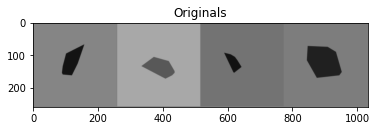

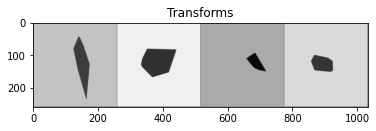

Transform parameters
tensor([  4.9800,  -0.4547, 231.8773,   0.7933,   1.7726], dtype=torch.float64)
tensor([  1.7136,  -0.3446, 206.3997,   1.0838,   1.6545], dtype=torch.float64)
tensor([  3.3347,   4.6768, 180.9387,   1.1259,   0.9411], dtype=torch.float64)
tensor([ -4.2266,  -2.4429, 344.5603,   0.7200,   0.4635], dtype=torch.float64)


In [9]:
def plotGrayScale(tensor, title):
  tensor = tensor / 2 + 0.5     # unnormalize
  npimg = tensor.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  # plt.show()

dataiter = iter(trainloader)
images, images_t,  labels = dataiter.next()

# show images
plotGrayScale(torchvision.utils.make_grid(images), "Originals")
plt.show()
plotGrayScale(torchvision.utils.make_grid(images_t), "Transforms")
plt.show()
print(f'Transform parameters')
for label in labels:
  print(label)


## Vanilla Pytorch CNN

In [27]:
class AffineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120) #TODO: Verify the math of 59536
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = AffineNet()

if torch.cuda.is_available():
  print(f'GPU : {torch.cuda.get_device_name(0)}')
  cuda0 = torch.device('cuda:0')
  net.cuda()

GPU : Tesla K80


## Optimizer

In [25]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [28]:
iter = 0
channels = 2
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
      
        batch_imgs, batch_imgs_t, labels = data
        ins = []
        #Stack both imgs as channels of the same image
        for im, im_t in zip(batch_imgs, batch_imgs_t):
          im = im.reshape((im.shape[1], im.shape[2]))
          im_t = im_t.reshape((im_t.shape[1], im_t.shape[2]))
          #TODO: Visulize stacked images here to make sure they are correct
          input = np.dstack((im, im_t))
          ins.append(input)
          # print(input.shape)

        
        # print(len(ins))
        inputs = np.zeros((batch_size, channels, IMG_WIDTH, IMG_HEIGHT))
        # print(inputs.shape)
        # print(inputs)
        if torch.cuda.is_available():
          inputs = Variable(torch.from_numpy(inputs).cuda())
          labels = Variable(labels.cuda())
          # labels = Variable(torch.from_numpy(labels).cuda())
        else:
          inputs = Variable(torch.from_numpy(inputs))
          labels = Variable(labels)
          # labels = Variable(torch.from_numpy(labels))

        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = inputs.to(device=cuda0, dtype=torch.float) #Convert to torch cuda float
        labels = labels.to(device=cuda0, dtype=torch.float)

        outputs = net(inputs)

        # outputs = outputs.reshape((400))

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0
        if i % 1 == 0:    # print every 2000 mini-batches
          print(f'iter {iter}, loss: {loss.item()}')
          # print('[%d, %5d] loss: %.3f' %
          #       (epoch + 1, i + 1, running_loss / 100))
          running_loss = 0.0
        iter += 1

print('Finished Training')

iter 0, loss: 8157.68896484375
iter 1, loss: 2696.146728515625
iter 2, loss: 8711.9423828125
iter 3, loss: 13903.0693359375
iter 4, loss: 4715.99365234375
iter 5, loss: 10728.1630859375
iter 6, loss: 5745.0029296875
iter 7, loss: 3136.376708984375
iter 8, loss: 5092.51953125
iter 9, loss: 2106.74853515625
iter 10, loss: 5354.5166015625
iter 11, loss: 18049.64453125
iter 12, loss: 9275.2568359375
iter 13, loss: 5511.38525390625
iter 14, loss: 6755.87646484375
iter 15, loss: 13794.0927734375
iter 16, loss: 13081.64453125
iter 17, loss: 14128.5390625
iter 18, loss: 13177.5537109375
iter 19, loss: 8452.3359375
iter 20, loss: 4978.92431640625
iter 21, loss: 10156.5068359375
iter 22, loss: 12374.859375
iter 23, loss: 10108.2255859375
iter 24, loss: 13356.3701171875
iter 25, loss: 6234.44482421875
iter 26, loss: 7421.4072265625
iter 27, loss: 9105.1171875
iter 28, loss: 10921.3125
iter 29, loss: 9024.958984375
iter 30, loss: 7005.42529296875
iter 31, loss: 6369.318359375


RuntimeError: ignored